In [1]:
import os
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import glob

classes = np.array(['ayam_bakar', 'ayam_crispy', 'bakso', 'gado2', 'ikan_bakar', 'mie_goreng', 'nasi_goreng', 'pecel_lele', 'pizza', 'rendang', 'sate', 'soto', 'sushi'])
num_classes = len(classes)
temp = classes.tolist()
 
def create_graph(model_path):
    """
    create_graph loads the inception model to memory, should be called before
    calling extract_features.
 
    model_path: path to inception model in protobuf form.
    """
    with gfile.FastGFile(model_path, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
        print 'selesai'
 
 
def extract_features(image_paths, verbose=False):
    """
    extract_features computed the inception bottleneck feature for a list of images
 
    image_paths: array of image path
    return: 2-d array in the shape of (len(image_paths), 2048)
    """
    features = []
    cls = []
    
    with tf.Session() as sess:
        flattened_tensor = sess.graph.get_tensor_by_name('pool_3:0')
 
        for fld in classes:
            index = temp.index(fld)
            path = os.path.join(image_paths, fld, '*.jpg')
            files = glob.glob(path)
            
            for fl in files:
                label = np.zeros(len(classes))
                label[index] = 1.0
                print '{0}\r'.format(fl),
                image_data = gfile.FastGFile(fl, 'rb').read()
                feature = sess.run(flattened_tensor, {
                    'DecodeJpeg/contents:0': image_data
                })
                features.append(feature)
                cls.append(label)
                
    return features, cls

In [2]:
path = 'tensorflow_inception_graph.pb'
create_graph(path)

selesai


In [3]:
image_paths = 'data_training/'
images, cls = extract_features(image_paths, verbose=False)
print "selesai"

selesaiaining/sushi/sushi (43).jpgjpg.jpgpg


In [4]:
image_paths = 'data_testing/'
images_test, cls_test = extract_features(image_paths, verbose=False)
print "selesai"

selesaisting/sushi/sushi (22).jpgpy).jpg


In [5]:
print len(images)
print len(images_test)
num_sample = len(images)
num_test = len(images_test)

5330
300


(1, 1, 1, 2048)


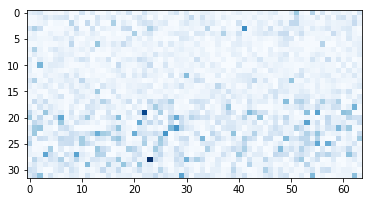

In [6]:
img = np.asarray(images[700])
print img.shape
img = img.reshape((32,64))

import matplotlib.pyplot as plt
# Plot the image for the transfer-values.
plt.imshow(img, interpolation='nearest', cmap='Blues')
plt.show()

In [7]:
transfer_values = np.asarray(images)
transfer_values = transfer_values.reshape((num_sample,2048))
print transfer_values.shape

transfer_values_test = np.asarray(images_test)
transfer_values_test = transfer_values_test.reshape((num_test,2048))
print transfer_values_test.shape



(5330, 2048)
(300, 2048)


In [8]:
cls = np.asarray(cls)
cls = cls.astype(int)
print cls.shape

cls_test = np.asarray(cls_test)
cls_test = cls_test.astype(int)
print cls_test.shape

(5330, 13)
(300, 13)


In [9]:
print cls

[[1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


In [12]:
cls2 = []
for tmp in cls:
    for i, a in enumerate (tmp):
        if a==1:
            cls2.append(i)

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transfer_values_reduced = pca.fit_transform(transfer_values)


In [14]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Get the color for each sample.
    colors = cmap[cls]

    # Extract the x- and y-values.
    x = values[:, 0]
    y = values[:, 1]

    # Plot it.
    plt.scatter(x, y, color=colors)
    plt.show()

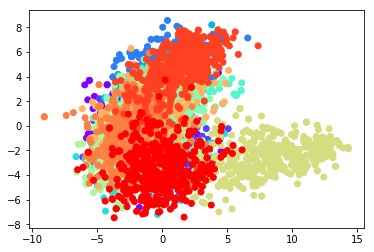

In [15]:
num_features = len(transfer_values[0])
plot_scatter(transfer_values_reduced, cls2)

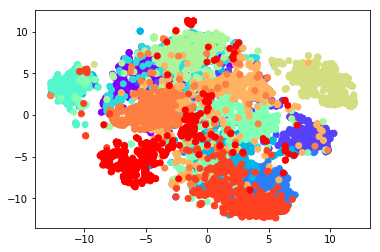

In [17]:
from sklearn.manifold import TSNE

pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)
tsne = TSNE(n_components=2)
transfer_values_reduced = tsne.fit_transform(transfer_values_50d)
plot_scatter(transfer_values_reduced, cls2)

In [22]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

feature_size_flat = num_features
x = tf.placeholder(tf.float32, shape=[None, feature_size_flat], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)


layer_fc1 = new_fc_layer(input= x,
                         num_inputs=num_features,
                         num_outputs=1000,
                         use_relu=True)
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=1000,
                         num_outputs=num_classes,
                         use_relu=False)
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



In [23]:
train_acc = []
test_acc = []

In [28]:
import time
saver = tf.train.Saver()
save_path = 'the_model2/model2'
session = tf.Session()
session.run(tf.global_variables_initializer())
#saver.restore(sess=session, save_path=save_path)


def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    total_iterations = 0

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_validation_accuracy = 0.0
    best_training_accuracy = 0.0
    best_loss = 1000
    last_improvement = 0
    require_improvement = num_iterations-1

    for i in range (num_iterations):
        
        feed_dict_train = {x: transfer_values,
                           y_true: cls}
        
        feed_dict_validate = {x: transfer_values_test,
                              y_true: cls_test}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        acc = session.run(accuracy, feed_dict=feed_dict_train)
        msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.2%}, Validation Accuracy: {2:>6.2%}, Validation loss: {3:>6.2%} {4}"
        acc_val = session.run(accuracy, feed_dict=feed_dict_validate)
        val_loss = session.run(cost, feed_dict=feed_dict_validate)
            
        if (acc_val > best_validation_accuracy) or (acc_val >= best_validation_accuracy and acc >= best_training_accuracy and val_loss < best_loss) or (acc_val >= best_validation_accuracy and acc > best_training_accuracy and val_loss <= best_loss):
            best_validation_accuracy = acc_val
            best_training_accuracy = acc
            best_loss = val_loss
            last_improvement = total_iterations
            saver.save(sess=session, save_path=save_path)
            sign = '*'
                # Print it.
            print(msg.format(i, acc, acc_val, val_loss, sign))
        else:
            sign = '-'
            print(msg.format(i, acc, acc_val, val_loss, sign))
    
    
    #update total_iteration
    #total_iterations += num_iterations
  
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

In [ ]:
optimize(num_iterations=5000)

Optimization Iteration:      0, Training Accuracy:  9.25%, Validation Accuracy:  8.33%, Validation loss: 260.87% *
Optimization Iteration:      1, Training Accuracy: 13.88%, Validation Accuracy: 11.33%, Validation loss: 247.70% *
Optimization Iteration:      2, Training Accuracy: 21.50%, Validation Accuracy: 17.67%, Validation loss: 237.75% *
Optimization Iteration:      3, Training Accuracy: 26.23%, Validation Accuracy: 23.33%, Validation loss: 229.12% *
Optimization Iteration:      4, Training Accuracy: 29.87%, Validation Accuracy: 26.00%, Validation loss: 220.19% *
Optimization Iteration:      5, Training Accuracy: 33.56%, Validation Accuracy: 28.33%, Validation loss: 210.34% *
Optimization Iteration:      6, Training Accuracy: 38.44%, Validation Accuracy: 32.33%, Validation loss: 199.92% *
Optimization Iteration:      7, Training Accuracy: 44.09%, Validation Accuracy: 39.00%, Validation loss: 189.63% *
Optimization Iteration:      8, Training Accuracy: 49.32%, Validation Accuracy: 

Optimization Iteration:     72, Training Accuracy: 88.91%, Validation Accuracy: 92.00%, Validation loss: 28.89% *
Optimization Iteration:     73, Training Accuracy: 89.02%, Validation Accuracy: 92.00%, Validation loss: 28.62% *
Optimization Iteration:     74, Training Accuracy: 89.08%, Validation Accuracy: 92.00%, Validation loss: 28.35% *
Optimization Iteration:     75, Training Accuracy: 89.19%, Validation Accuracy: 92.00%, Validation loss: 28.10% *
Optimization Iteration:     76, Training Accuracy: 89.36%, Validation Accuracy: 92.00%, Validation loss: 27.86% *
Optimization Iteration:     77, Training Accuracy: 89.44%, Validation Accuracy: 92.00%, Validation loss: 27.62% *
Optimization Iteration:     78, Training Accuracy: 89.62%, Validation Accuracy: 91.67%, Validation loss: 27.40% -
Optimization Iteration:     79, Training Accuracy: 89.74%, Validation Accuracy: 91.67%, Validation loss: 27.18% -
Optimization Iteration:     80, Training Accuracy: 89.77%, Validation Accuracy: 91.67%, 

Optimization Iteration:    144, Training Accuracy: 94.35%, Validation Accuracy: 92.67%, Validation loss: 19.44% *
Optimization Iteration:    145, Training Accuracy: 94.43%, Validation Accuracy: 92.67%, Validation loss: 19.38% *
Optimization Iteration:    146, Training Accuracy: 94.48%, Validation Accuracy: 92.67%, Validation loss: 19.31% *
Optimization Iteration:    147, Training Accuracy: 94.48%, Validation Accuracy: 92.67%, Validation loss: 19.24% -
Optimization Iteration:    148, Training Accuracy: 94.54%, Validation Accuracy: 92.67%, Validation loss: 19.18% *
Optimization Iteration:    149, Training Accuracy: 94.58%, Validation Accuracy: 92.67%, Validation loss: 19.12% *
Optimization Iteration:    150, Training Accuracy: 94.62%, Validation Accuracy: 92.67%, Validation loss: 19.05% *
Optimization Iteration:    151, Training Accuracy: 94.63%, Validation Accuracy: 92.67%, Validation loss: 18.99% *
Optimization Iteration:    152, Training Accuracy: 94.65%, Validation Accuracy: 92.67%, 

Optimization Iteration:    216, Training Accuracy: 97.11%, Validation Accuracy: 93.67%, Validation loss: 16.36% *
Optimization Iteration:    217, Training Accuracy: 97.11%, Validation Accuracy: 93.67%, Validation loss: 16.33% *
Optimization Iteration:    218, Training Accuracy: 97.15%, Validation Accuracy: 93.67%, Validation loss: 16.31% *
Optimization Iteration:    219, Training Accuracy: 97.17%, Validation Accuracy: 93.67%, Validation loss: 16.28% *
Optimization Iteration:    220, Training Accuracy: 97.19%, Validation Accuracy: 93.67%, Validation loss: 16.26% *
Optimization Iteration:    221, Training Accuracy: 97.20%, Validation Accuracy: 93.67%, Validation loss: 16.23% *


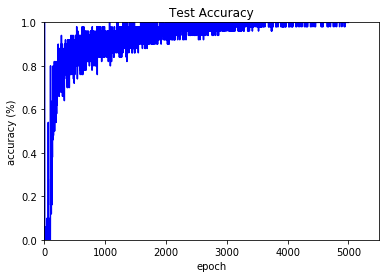

In [45]:
plt.plot(train_acc, color = 'blue')
plt.title('Test Accuracy')
plt.xlim(0, 5500)
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.show()

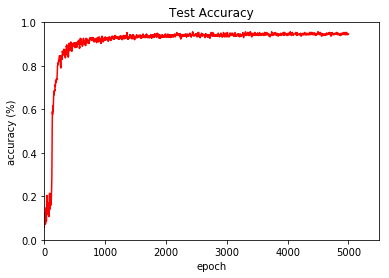

In [44]:
plt.plot(test_acc, color = 'red')
plt.title('Test Accuracy')
plt.xlim(0, 5500)
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.show()

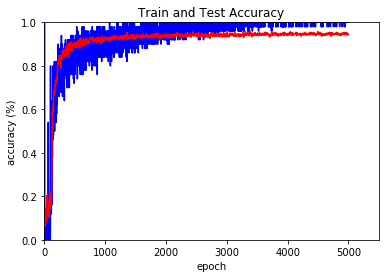

In [51]:
plt.figure(1)
plt.title('Train and Test Accuracy')
plt.plot(train_acc, color = 'blue')
plt.xlim(0, 5500)
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')

plt.figure(1)
plt.plot(test_acc, color = 'red')
plt.xlim(0, 5500)
plt.ylim(0, 1)

plt.show()


In [53]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [59]:
def print_validation_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + 50, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :].reshape(batch_size, img_size_flat)
        

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

ValueError: Cannot feed value of shape (2048,) for Tensor u'x:0', which has shape '(?, 2048)'

In [60]:
print tensor_values

NameError: name 'tensor_values' is not defined